### Predict House Price in California (Kaggle)

### Import Libraries

In [1]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

### Data Loading and Pre-processing

In [2]:
class dataset(object):
    def __init__(self,train,list_ftr,ftr_target=None):
        ''' Initialize dataset class '''
        self.str_encoder = dict()
        self.imputer = dict()
        self.scaler = dict()
        self.train = train[list_ftr]
        flag_numeric = (self.train.dtypes == 'int64') | (self.train.dtypes == 'float64')
        flag_string = (self.train.dtypes == 'object')
        df_string = self.train.loc[:, flag_string.values.tolist()]
        df_numeric = self.train.loc[:, flag_numeric.values.tolist()]        
        self.label_encoder(df_string, df_numeric)
        self.train = pd.concat([df_numeric, df_string],axis=1)
        self.train = self.train.reindex(sorted(self.train.columns), axis=1)  

    def label_encoder(self,df_string,df_numeric):
        ''' Convert categorical data into discrete numbers '''
        for col_name in df_string.columns:
            series = df_string[col_name]
            le = LabelEncoder()
            df_string = df_string.copy()
            df_string.loc[:,col_name] = pd.Series(le.fit_transform(series[series.notnull()]),
                                                      index=series[series.notnull()].index)
            self.str_encoder[col_name] = le
        
    def Imputer(self,list_conv,strategy='mean'):
        ''' Replace missing values (NaN) with mean value of the given attribute'''
        for ftr in list_conv:
            X = self.train[ftr].values.astype('float64').reshape(-1,1)
            imputer = SimpleImputer(missing_values=np.nan, strategy=strategy).fit(X)
            self.train[ftr] = imputer.transform(X)
            self.imputer[ftr] = imputer
            
    def Stdzer(self,list_conv):
        ''' Standardize continuous data and retain scaling factor '''
        for ftr in list_conv:
            X = self.train[ftr].values.astype('float64').reshape(-1,1)
            scaler = StandardScaler().fit(X)
            self.train[ftr] = scaler.transform(X)
            self.scaler[ftr] = scaler
            
    def Nrmlzer(self,list_conv):
        ''' Clip data by '''        
        for ftr in list_conv:
            X = self.train[ftr].values.astype('float64').reshape(-1,1)
            scaler = MinMaxScaler().fit(X)
            self.train[ftr] = scaler.transform(X)
            self.scaler[ftr] = scaler
            
    def test_data(self,test,list_conv):
        ''' Save Feature Engineering Parameter for Inverse Transform '''
        self.test = test[list_conv].copy()
        for ftr in list_conv:
            X = self.test[ftr].values.astype('float64').reshape(-1,1)
            if ftr in self.str_encoder.keys():
                X = self.str_encoder[ftr].transform(X)
            if ftr in self.imputer.keys():
                X = self.imputer[ftr].transform(X)
            if ftr in self.scaler.keys():
                X = self.scaler[ftr].transform(X)
            self.test.loc[:,ftr] = X

In [3]:
# Data Loading
path = os.getcwd() + '/Data/'
df_train_all = pd.read_csv(path + 'train.csv', index_col=None)
df_test_all  = pd.read_csv(path + 'test.csv', index_col=None)

# List of features
list_ftr_use = ['SalePrice','1stFlrSF','2ndFlrSF','BedroomAbvGr','BsmtFinSF1',
                'BsmtUnfSF','GarageArea','GarageCars','GrLivArea','MSSubClass',
                'MoSold','OpenPorchSF','OverallCond','OverallQual','TotRmsAbvGrd',
                'TotalBsmtSF','WoodDeckSF','YearBuilt','YearRemodAdd','YrSold']
data = dataset(df_train_all, list_ftr_use)

In [4]:
# Feature Engineering
list_ftr_std = ['SalePrice','1stFlrSF','BedroomAbvGr','GarageArea','GarageCars',
                'GrLivArea','MoSold','OverallCond','OverallQual','TotRmsAbvGrd',
                'TotalBsmtSF']

list_ftr_nrm = ['2ndFlrSF','BsmtFinSF1','BsmtUnfSF','MSSubClass','MoSold',
                'OpenPorchSF','WoodDeckSF','YearBuilt','YearRemodAdd','YrSold']
data.Imputer(list_ftr_use)
data.Stdzer(list_ftr_std)
data.Nrmlzer(list_ftr_nrm)
data.test_data(df_test_all,list_ftr_use[1:])

### Principal Component Analysis

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.decomposition import PCA
from collections import OrderedDict

In [6]:
class pca_wrapper:
    def __init__(self, df_X, num_pc = 2):
        ''' Initialize pca_wrapper class '''
        self.num_pc = num_pc
        self.pca = PCA(n_components = self.num_pc).fit(df_X)
        self.ftr_list = df_X.columns.tolist()
        self.X = df_X.values
        self.X_trans = self.pca.transform(df_X)
        self.loading()

    def loading(self):
        ''' Loading factors for each features for each pc '''
        pc_num = np.arange(1,self.num_pc + 1, 1)
        eigen = self.pca.explained_variance_
        eigen_r = self.pca.explained_variance_ratio_ * 100   
        idx_pc = ['PC' + str(i) for i in pc_num]
        self.df_load = pd.DataFrame(self.pca.components_, columns = self.ftr_list, index = idx_pc)
        self.summary = pd.DataFrame({'Eigen value': eigen.tolist(),
                                     'Contribution [%]':eigen_r.tolist(),
                                     'Cum Contrib [%]': np.cumsum(eigen_r.tolist())},
                                      index = idx_pc)

In [7]:
# Model Order Reduction by PCA
X_train = data.train.drop(['SalePrice'], axis=1)
pca_train = pca_wrapper(X_train, num_pc = 8)
data_rom = pca_train.pca.transform(X_train)
X_test_rom = pca_train.pca.transform(data.test)
target = data.train['SalePrice'].values

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
def screeplot(ax,pca_result):
    ''' Scree plot to visualize contribution of each pc to explain whole dataset '''
    eigenvalues = pca_result.pca.explained_variance_
    cum_contrib = np.cumsum(pca_result.pca.explained_variance_ratio_)*100
    plt.plot(eigenvalues, ls = '-', color = 'b', marker = 'x')
    plt.plot([-1, pca_result.num_pc], [1, 1], ls = '--', color = 'gray')
    plt.xlim([-1, pca_result.num_pc])
    plt.ylim([0, np.round(np.max(eigenvalues)) + 1])
    xticks = ['#'+str(i) for i in np.arange(1,pca_result.num_pc + 1, 1)]
    plt.xticks(np.arange(0,pca_result.num_pc), xticks)
    plt.ylabel('Eigen Value')
    plt.xlabel('Principle Component')    
    ax.twinx()
    plt.plot(cum_contrib, ls = '-', color = 'r', marker = 'o')
    plt.ylabel('Cumulative Contribution [%]')                   
    plt.title('Scree Plot')

In [10]:
def pc_plot(ax,pca_result, idx_pc_disp = [0,1]):
    # Principle Components
    plt.grid(zorder = 0)
    x = pca_result.X_trans[:,idx_pc_disp[0]]
    y = pca_result.X_trans[:,idx_pc_disp[1]]
    plt.scatter(x,y,c='green',alpha=0.2,marker='*',zorder=3)
    plt.xlabel('PC' + str(idx_pc_disp[0] + 1))
    plt.ylabel('PC' + str(idx_pc_disp[1] + 1))

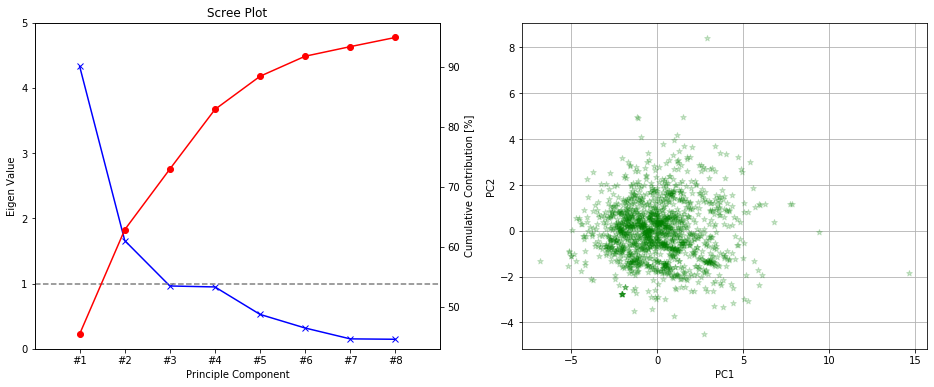

In [11]:
fig = plt.subplots(1, 2, figsize=(16, 6))
ax1 = plt.subplot(121)
screeplot(ax1,pca_train)
ax2 = plt.subplot(122)
pc_plot(ax2,pca_train,[0,1])
plt.show()

### Feature Importance & Principal Components

In [12]:
def pc_mat_importance(data,target,pca_model):
    ''' Visualize Principal Component-Feature Matrix by Heatmap '''

    import operator
    # Sort Columns by PC values
    dict_pca = pca_model.df_load.copy()
    dict_sort = dict_pca.abs().sum().to_dict()
    sorted_d = OrderedDict(sorted(dict_sort.items(),key=operator.itemgetter(1),reverse=True))
    columns_sorted = list(sorted_d)

    # Sort by Eigen value of Prinicpal Component Analysis
    eigenvalues = pca_model.pca.explained_variance_
    importance = eigenvalues/sum(eigenvalues)
    
    # Display Heat map
    fig, ax = plt.subplots(figsize = (16,5))
    ax = sns.heatmap(dict_pca[columns_sorted],cmap='coolwarm', linewidth=0.5,
                     vmin=-1, vmax=1, cbar_kws={'label': 'Principal axes in feature space'})
    imp_pc_zip = sorted(zip(importance, np.arange(1,pca_model.num_pc + 1, 1)), reverse=True)    
    idx_pc = ['PC'+str(i)+': '+'{:.1f}'.format(imp*100)+'%' for imp, i in imp_pc_zip]
    ax.set_yticklabels(idx_pc, rotation=30)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    plt.ylabel('Feature Importance sorted by PCA', fontsize=12)
    plt.show()

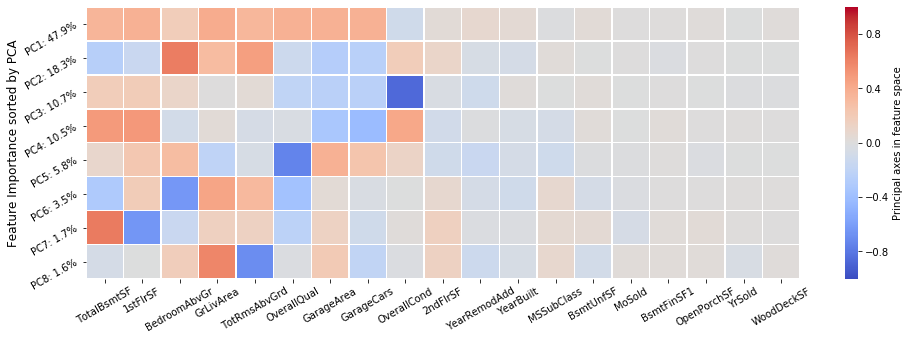

In [13]:
pc_mat_importance(data_rom,target,pca_train)

### Plot Eigen Vectors for two given features

In [14]:
def plot_eigenvector(pca_result, ftrs, eigenvecs = [0,1]):
    ''' Plot eigen vector for each principal component '''
    column_list = list(pca_result.df_load.columns)
    idx_x = column_list.index(ftrs[0])
    idx_y = column_list.index(ftrs[1])

    fig, ax = plt.subplots(figsize=(7,7))
    ax.patch.set_facecolor('#B5B5B5')
    plt.grid(b=True, which='minor',color='w',linestyle='--',linewidth=0.2,zorder=-1)    
    plt.grid(b=True, which='major',color='w',linestyle='-',linewidth=0.5,zorder=-1)    
    plt.scatter(pca_result.X[:,idx_x],pca_result.X[:,idx_y],alpha=0.2,color='white',marker='o',zorder = 3)
    vec_load = []
    for length, vector in zip(pca_result.pca.explained_variance_, pca_result.pca.components_):
        vec_load.append(vector * np.sqrt(length))

    # Eigen Vectors
    scaler = 3
    list_clr = ['magenta','cyan','yellow','green','red','blue','purple','brown']
    for ith_vec in np.arange(pca_result.pca.n_components):
        plt.arrow(pca_result.pca.mean_[idx_x],
                  pca_result.pca.mean_[idx_y],
                  scaler * vec_load[ith_vec][idx_x],
                  scaler * vec_load[ith_vec][idx_y], 
                  head_width = 0.1, head_length = 0.1,
                  color = list_clr[ith_vec], zorder = 5)
        plt.plot([],[],color=list_clr[ith_vec],label='PC' + str(ith_vec+1))
    ax.set_xlim([-5,5])
    ax.set_ylim([-5,5])    
    plt.xlabel(pca_result.ftr_list[idx_x])
    plt.ylabel(pca_result.ftr_list[idx_y])
    plt.legend()

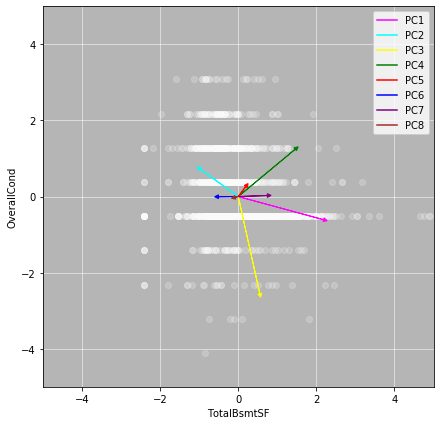

In [15]:
plot_eigenvector(pca_train, ftrs=['TotalBsmtSF','OverallCond'], eigenvecs=[0,1])

### Random Forest Regressor

In [16]:
class rf_wrapper:
    # Regression by Random Forest
    def __init__(self,data,target,pca_comp):
        ''' Initialize rf_wrapper class '''
        self.pca = pca_comp.pca
        self.df_load = pca_comp.df_load
        self.num_pc = pca_comp.num_pc
        self.data = data
        self.target = target
        self.RF_Regressor()
        
    def RF_Regressor(self):
        ''' Regression by Random Forest '''
        X_train, X_test, y_val, y_val = train_test_split(self.data,self.target,test_size=0.3)
        param_grid = [{'n_estimators':[100], 'max_depth':[20]}]        
        RFR = RandomForestRegressor()
        grid_search = GridSearchCV(RFR,param_grid,cv=5,scoring='neg_mean_squared_error')
        grid_search.fit(self.data,self.target)
        self.ftr_imp = grid_search.best_estimator_.feature_importances_        
        model = grid_search.best_estimator_
        predicted = model.predict(X_test)
        print(grid_search.best_params_)
        print("RMSE = %0.3f" % np.sqrt(mse(y_val, predicted)))
        print("R2 score = %0.3f" % r2_score(y_val, predicted))       # coefficient of determination
        self.regr = model
        
    def feature_importance(self):
        ''' Feature Engineering '''
        importance = self.ftr_imp.copy()
        rankftr = np.argsort(importance)[::-1]
        importance = [importance[i] for i in rankftr]
        columns = ['PC' + str(x) for x in np.arange(1,rf_regr.num_pc+1,1)]
        columns = [columns[i] for i in rankftr]
        print('\nImportance of features')
        for feature in zip(columns,importance):
            print(feature[0].ljust(12) + ': ' + '{:.2f}'.format(100*feature[1]).rjust(5) + '%')
        print('\n')        

In [17]:
rf_regr = rf_wrapper(data_rom,target,pca_train)
y_train_pred_sc = rf_regr.regr.predict(data_rom)
y_train_pred = data.scaler['SalePrice'].inverse_transform(y_train_pred_sc)
y_test_pred_sc = rf_regr.regr.predict(X_test_rom)
y_test_pred = data.scaler['SalePrice'].inverse_transform(y_test_pred_sc)
rf_regr.feature_importance()

{'max_depth': 20, 'n_estimators': 100}
RMSE = 0.141
R2 score = 0.982

Importance of features
PC1         : 79.21%
PC5         :  6.98%
PC3         :  3.40%
PC4         :  2.52%
PC8         :  2.28%
PC2         :  2.25%
PC6         :  1.93%
PC7         :  1.43%




### Predicted vs Actual prices

In [18]:
def AxConfig(ax,prmax):
    ''' Configure Axis '''
    ax.set_xlim([prmax['xmin'],prmax['xmax']])
    ax.set_ylim([prmax['ymin'],prmax['ymax']])
    ax.set_xticks(np.arange(prmax['xmin'],prmax['xmax'] + 1e-6,prmax['xmajor']))    
    ax.set_yticks(np.arange(prmax['ymin'],prmax['ymax'] + 1e-6,prmax['ymajor']))
    ax.set_xticks(np.arange(prmax['xmin'],prmax['xmax'] + 1e-6,prmax['xminor']),minor=True)
    ax.set_yticks(np.arange(prmax['ymin'],prmax['ymax'] + 1e-6,prmax['yminor']),minor=True)    
    plt.grid(b=True,which='minor',color='w',linestyle='--',linewidth=0.2,zorder=-1)    
    plt.grid(b=True,which='major',color='w',linestyle='-',linewidth=0.5,zorder=-1)    
    ax.patch.set_facecolor('#B5B5B5')

In [19]:
def crossplot(actual,predicted):
    ''' Crosplot Actual and Predicted House Prices '''
    fig, ax = plt.subplots(figsize=(6,6))
    ax.patch.set_facecolor('#B5B5B5')
    prmax = {'xmin':0,'xmax':800,'xmajor':200,'xminor':100,
             'ymin':0,'ymax':800,'ymajor':200,'yminor':100}
    AxConfig(ax,prmax)
    r2_str = '$R^{%d}$'%2 +': ' + '{:.3f}'.format(r2_score(actual, predicted))
    ax.text(50, 700, r2_str, fontsize=12)
    plt.scatter(actual,predicted,c='yellow',s=20,marker='*')
    plt.xlabel('Actual [M$]')
    plt.ylabel('Predicted [M$]')
    plt.show()

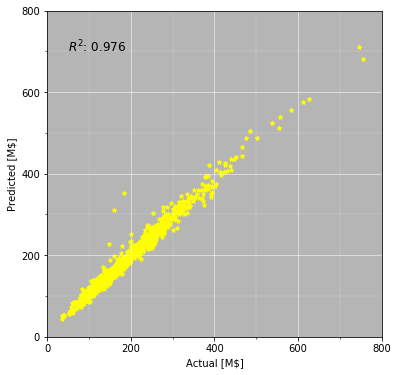

In [20]:
actual = df_train_all.SalePrice.values / 1e3
predicted = y_train_pred / 1e3
crossplot(actual,predicted)

### Submission

In [21]:
import datetime
sample = pd.read_csv(path + 'sample_submission.csv')
Submit = sample.copy()
Submit['SalePrice'] = y_test_pred
now = datetime.datetime.now().strftime("%Y%m%d%H%M")
Submit.to_csv(path+'submission_' + now +'.csv',index=False)